In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load dataset
data = pd.read_csv('train.csv')
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1),
    data['SalePrice'], 
    test_size=0.2, 
    random_state=0, 
)

X_train.shape, X_test.shape

((1168, 79), (292, 79))

## 1. Target Variable

In [4]:
# tranform the target variable by applying tyhe logarithm
y_train = np.log(y_train)
y_test = np.log(y_test)

## 2. Missing Values

### 2.1 Categorical Variables

In [5]:
# capture object type object

cat_vars = [var for var in data.columns if data[var].dtype == 'O']

# note: MSSubClass is also categorical by the data description file
cat_vars = cat_vars + ['MSSubClass']

# cast all variables as categorical
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

# number of categorical variables
len(cat_vars)

44

In [6]:
# categorical variables that contain missing values

cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
]

# print % of missing values 
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)


PoolQC          0.996575
MiscFeature     0.958048
Alley           0.939212
Fence           0.816781
FireplaceQu     0.471747
GarageType      0.049658
GarageFinish    0.049658
GarageQual      0.049658
GarageCond      0.049658
BsmtFinType2    0.024829
BsmtQual        0.023973
BsmtCond        0.023973
BsmtExposure    0.023973
BsmtFinType1    0.023973
MasVnrType      0.005137
Electrical      0.000856
dtype: float64

In [7]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < 0.1]

In [8]:
with_string_missing

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [9]:
# replace missing values with new label: "Missing"
X_train[with_string_missing] = X_train[with_string_missing].fillna('Missing')
X_test[with_string_missing] = X_test[with_string_missing].fillna('Missing')

In [10]:
for var in with_frequent_category:
    
    # there can be more than 1 mode in a variable
    # so take the first one with [0]    
    mode = X_train[var].mode()[0]
    
    print(var, mode)
    
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)

MasVnrType None
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 Unf
BsmtFinType2 Unf
Electrical SBrkr
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA


In [11]:
# check if there is missing information
X_train[cat_vars_with_na].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [12]:
# check if there is null values
[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]


[]

### 2.2 Numerical variables

To deal with missing values in numerical variables:

* add a binary missing indicator variable
* replace the missing values in the original variable with the mean

In [13]:
# the numerical variables
num_vars = [
    var for var in X_train.columns if var not in cat_vars and var != 'SalePrice'
]

# count
len(num_vars)

35

In [14]:
# numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print % of missing values
X_train[vars_with_na].isnull().mean()

LotFrontage    0.181507
MasVnrArea     0.005137
GarageYrBlt    0.049658
dtype: float64

In [15]:
for var in vars_with_na:

    # calculate the mean using the train set
    mean_val = X_train[var].mean()
    
    print(var, mean_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean (in train and test)
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

# check that there is no more missing values
X_train[vars_with_na].isnull().sum()

LotFrontage 69.61401673640168
MasVnrArea 103.48106712564544
GarageYrBlt 1978.1405405405405


LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [16]:
# check if test set contain null values 
[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

In [17]:
# check the binary missing indicator variables
X_train[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
618,0,0,0
870,0,0,0
92,0,0,0
817,1,0,0
302,0,0,0


## 3. Temporal Variables

In [18]:
# capture elapsed time
def elapsed_years(df, var):
    # difference between the year variable and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [19]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [20]:
# now we drop YrSold
X_train.drop(['YrSold'], axis=1, inplace=True)
X_test.drop(['YrSold'], axis=1, inplace=True)

## 4. Numerical Variable Transformation

### 4.1 Logarithmic Transformation

In [21]:
# transform the positive numerical variables to 
# be similar with the normal distribution
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

In [22]:
# check if the test set contain null values in the variables
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_test[var].isnull().sum() > 0]

[]

In [23]:
# same for train set
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_train[var].isnull().sum() > 0]

[]

### 4.2 Yeo-Johnson transformation

In [24]:
# the yeo-johnson transformation learns the best exponent to transform the variable
# it needs to learn it from the train set: 
X_train['LotArea'], param = stats.yeojohnson(X_train['LotArea'])

# apply the transformation to the test set with the same parameter
X_test['LotArea'] = stats.yeojohnson(X_test['LotArea'], lmbda=param)

print(param)

0.01117384818569117


In [25]:
# check if na in the training set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [26]:
# check if na in the test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0] 

[]

### 4.3 Binarize skewed variables

In [27]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:
    
    # map the variable values into 0 and 1
    X_train[var] = np.where(X_train[var]==0, 0, 1)
    X_test[var] = np.where(X_test[var]==0, 0, 1)

## 5. Categorical Variables

### 5.1 Apply mappings

In [28]:
# re-map strings to numbers, which relates to quality
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    X_train[var] = X_train[var].map(qual_mappings)
    X_test[var] = X_test[var].map(qual_mappings)

In [29]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

X_train[var] = X_train[var].map(exposure_mappings)
X_test[var] = X_test[var].map(exposure_mappings)

In [30]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)

In [31]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)

In [32]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

In [33]:
# check if na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

### 5.2 Remove Rare Labels

For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations. Specifically, all values of categorical variables that are shared by less than 1% of houses, will be replaced by the string "Rare".

In [34]:
# capture all quality variables

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']

# capture the remaining categorical variables, which we did not re-map)

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

30

In [35]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_others:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

MSZoning Index(['FV', 'RH', 'RL', 'RM'], dtype='object', name='MSZoning')

Street Index(['Pave'], dtype='object', name='Street')

Alley Index(['Grvl', 'Missing', 'Pave'], dtype='object', name='Alley')

LotShape Index(['IR1', 'IR2', 'Reg'], dtype='object', name='LotShape')

LandContour Index(['Bnk', 'HLS', 'Low', 'Lvl'], dtype='object', name='LandContour')

Utilities Index(['AllPub'], dtype='object', name='Utilities')

LotConfig Index(['Corner', 'CulDSac', 'FR2', 'Inside'], dtype='object', name='LotConfig')

LandSlope Index(['Gtl', 'Mod', 'Sev'], dtype='object', name='LandSlope')

Neighborhood Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber'],
      dtype='object', name='Neighborhood')

Condition1 Index(['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'], dtype='object', name='Condition1

### 5.4 Encoding of categorical variables

In [36]:
# assign discrete values to the strings of the variables,
# so the smaller value corresponds to the category that shows 
# the smaller mean house sale price

def replace_categories(train, test, y_train, var, target):
    
    tmp = pd.concat([X_train, y_train], axis=1)
    
    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = tmp.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    
    print(var, ordinal_label)
    print()

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [37]:
for var in cat_others:
    replace_categories(X_train, X_test, y_train, var, 'SalePrice')

MSZoning {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Street {'Rare': 0, 'Pave': 1}

Alley {'Grvl': 0, 'Pave': 1, 'Missing': 2}

LotShape {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3}

LandContour {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}

Utilities {'Rare': 0, 'AllPub': 1}

LotConfig {'Rare': 0, 'Inside': 1, 'Corner': 2, 'FR2': 3, 'CulDSac': 4}

LandSlope {'Gtl': 0, 'Mod': 1, 'Sev': 2}

Neighborhood {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3, 'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7, 'NAmes': 8, 'Mitchel': 9, 'Rare': 10, 'SawyerW': 11, 'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15, 'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19, 'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22}

Condition1 {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5}

Condition2 {'Rare': 0, 'Norm': 1}

BldgType {'2fmCon': 0, 'Twnhs': 1, 'Duplex': 2, 'TwnhsE': 3, '1Fam': 4}

HouseStyle {'1.5Unf': 0, 'SFoyer': 1, '1.5Fin': 2, 'SLvl': 3, '1Story': 4, 'Rare':

In [38]:
# check if na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [39]:
# check if na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

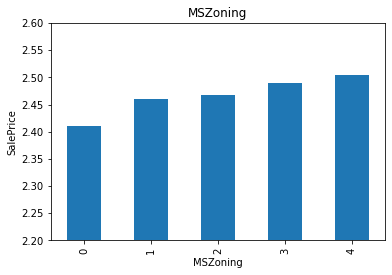

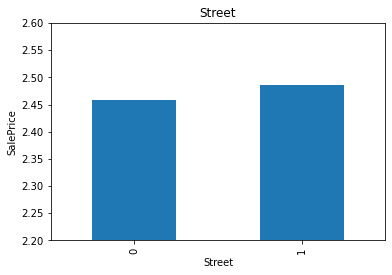

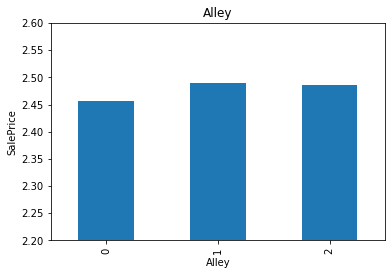

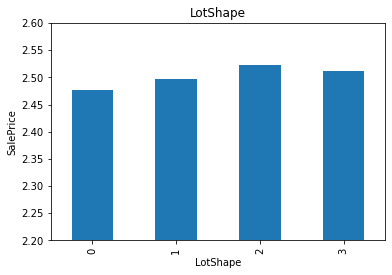

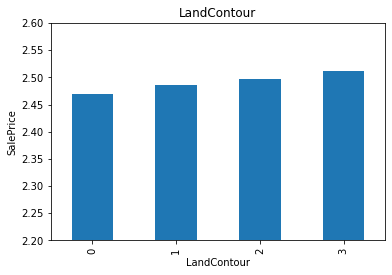

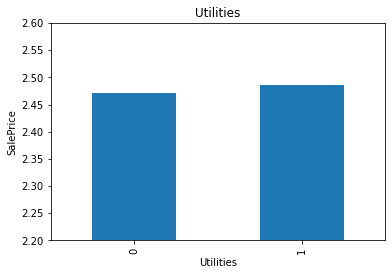

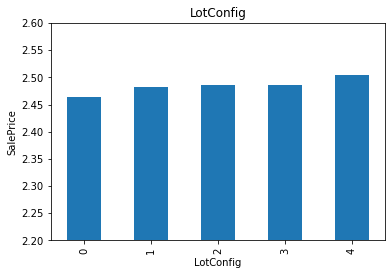

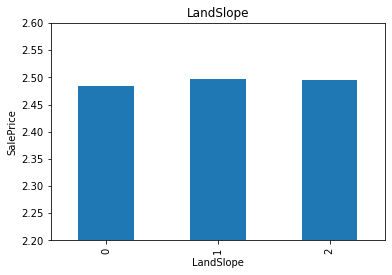

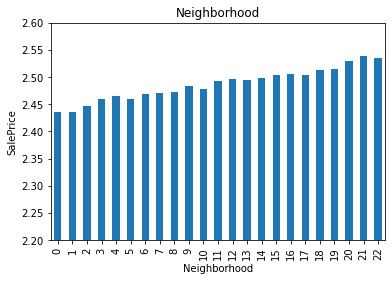

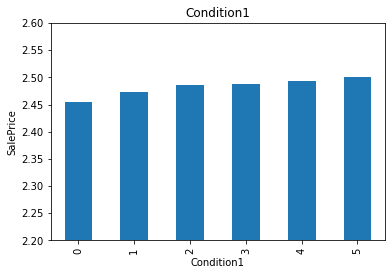

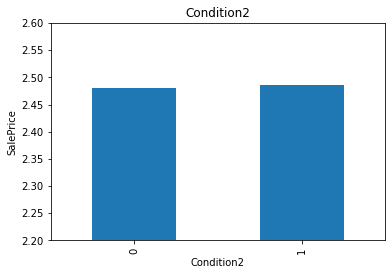

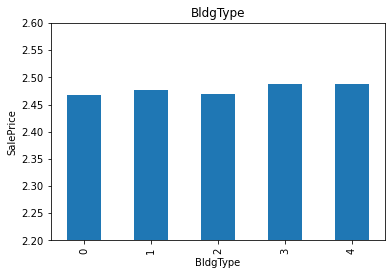

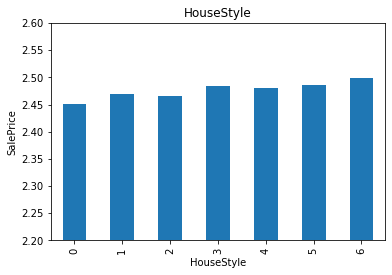

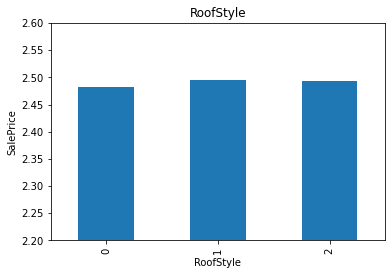

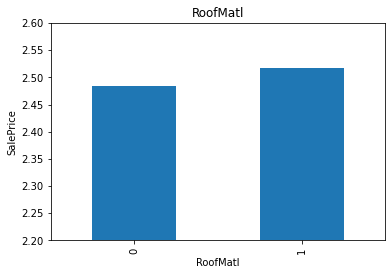

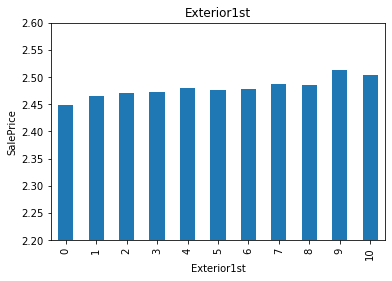

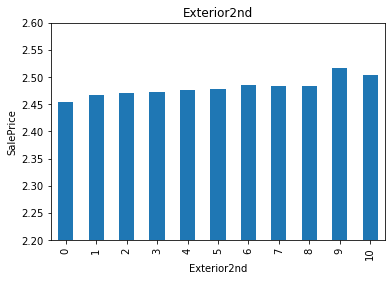

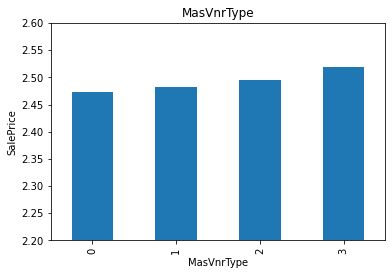

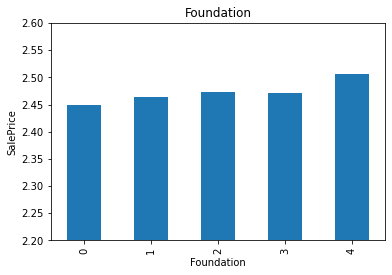

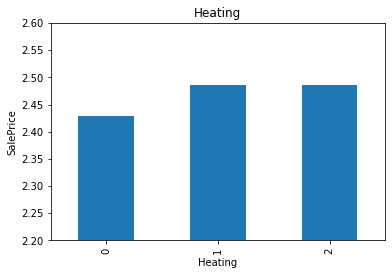

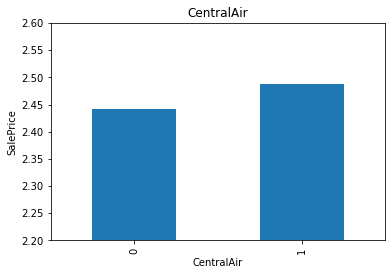

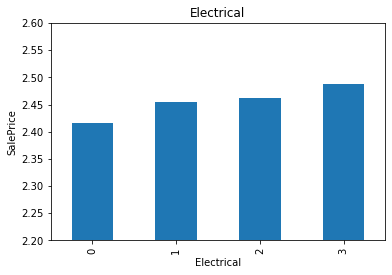

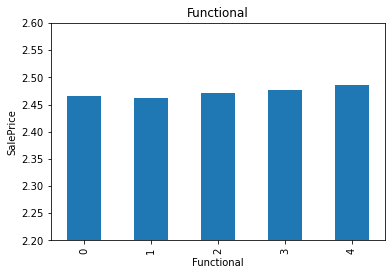

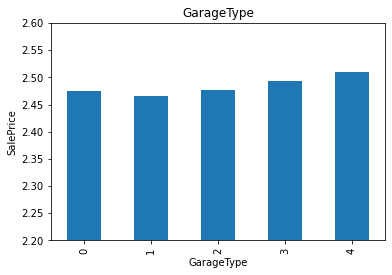

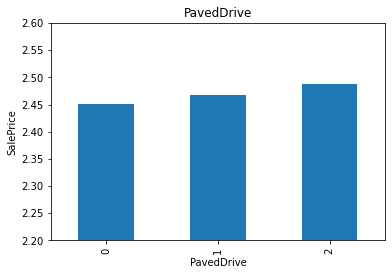

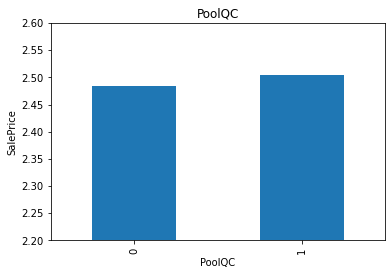

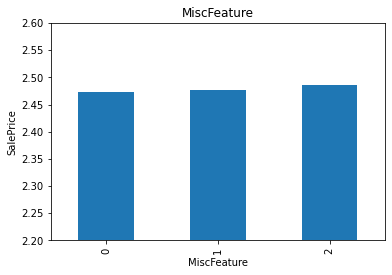

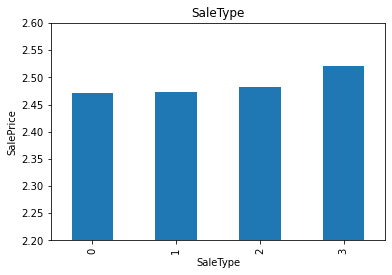

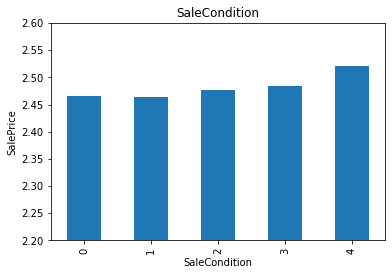

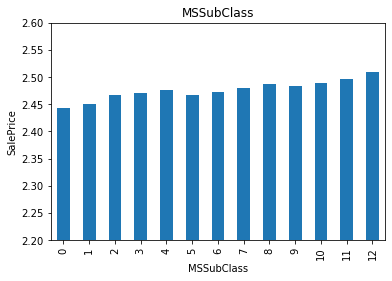

In [40]:
# show the monotonic relationship between labels and target

def analyse_vars(train, y_train, var):
    
    # plots median house sale price per encoded category
    
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    
    tmp.groupby(var)['SalePrice'].median().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel('SalePrice')
    plt.show()
    
for var in cat_others:
    analyse_vars(X_train, y_train, var)

The monotonic relationship is significantly clear for the variables MSZoning and Neighborhood. (Note that the target is log-transformed, that is why the differences seem so small).

## 6. Feature Scaling

In [41]:
# create scaler
scaler = MinMaxScaler()

#  fit the train set
scaler.fit(X_train) 

# transform the train and test set
# sklearn returns numpy arrays, so need to wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [42]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.75,0.75,0.538660,0.422880,1.0,1.0,0.000000,0.333333,1.0,0.25,0.0,0.954545,0.4,1.0,1.0,0.666667,0.888889,0.50,0.000000,0.016393,1.0,0.0,0.9,0.9,0.666667,0.28250,1.000000,0.50,1.00,1.000000,0.666667,0.666667,1.0,0.021239,0.0,0.0,0.823967,0.568309,0.5,1.00,1.0,1.0,0.749329,0.0,0.0,0.644108,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.583333,1.0,0.333333,0.8,0.75,0.000000,0.0,0.75,0.556835,0.5,0.5,1.0,0.000000,0.197441,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.545455,1.000000,1.00,0.0,0.0,0.0
1,0.75,0.75,0.388581,0.311742,1.0,1.0,0.000000,0.333333,1.0,0.25,0.0,0.363636,1.0,1.0,1.0,0.666667,0.444444,0.50,0.345588,0.786885,1.0,0.0,0.3,0.3,0.000000,0.00000,0.333333,0.50,0.50,0.333333,0.666667,0.000000,0.0,0.000000,0.0,0.0,0.415235,0.278852,0.5,0.75,0.0,1.0,0.434020,0.0,0.0,0.373074,0.000000,0.0,0.333333,0.0,0.250,0.333333,0.333333,0.250000,1.0,0.000000,0.0,0.25,0.439252,0.0,0.25,0.221583,0.5,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.636364,0.666667,0.75,0.0,0.0,0.0
2,0.00,0.75,0.495064,0.448860,1.0,0.0,0.333333,1.000000,1.0,0.25,0.0,0.727273,0.4,1.0,1.0,0.666667,0.444444,0.75,0.647059,0.065574,0.0,0.0,0.2,0.2,0.000000,0.00000,0.333333,0.75,0.25,0.666667,0.666667,0.000000,0.8,0.315487,0.0,0.0,0.075708,0.273238,0.5,1.00,1.0,1.0,0.467252,0.0,0.0,0.401640,0.333333,0.0,0.333333,0.0,0.250,0.333333,0.333333,0.250000,1.0,0.000000,0.0,0.25,0.822430,0.0,0.50,0.310791,0.5,0.5,1.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.636364,0.666667,0.75,0.0,0.0,0.0
3,0.75,0.75,0.443592,0.447467,1.0,1.0,0.333333,0.333333,1.0,1.00,0.0,0.409091,0.4,1.0,1.0,0.666667,0.777778,0.50,0.044118,0.114754,1.0,0.0,0.9,0.9,0.666667,0.09250,0.666667,0.50,1.00,0.666667,0.666667,0.000000,1.0,0.538938,0.0,0.0,0.162564,0.489083,0.5,1.00,1.0,1.0,0.714467,0.0,0.0,0.614140,0.333333,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.666667,0.8,0.75,0.056075,0.5,0.75,0.616547,0.5,0.5,1.0,0.203804,0.107861,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.545455,0.666667,0.75,1.0,0.0,0.0
4,0.75,0.75,0.638922,0.453824,1.0,1.0,0.333333,0.333333,1.0,0.50,0.0,0.681818,0.4,1.0,1.0,0.666667,0.666667,0.50,0.036765,0.081967,0.0,0.0,1.0,1.0,0.666667,0.09375,0.666667,0.50,1.00,0.666667,0.666667,0.000000,0.0,0.000000,0.0,0.0,0.715745,0.480661,0.5,1.00,1.0,1.0,0.674041,0.0,0.0,0.579391,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.333333,1.0,0.333333,0.6,0.75,0.046729,0.5,0.75,0.606475,0.5,0.5,1.0,0.635870,0.148080,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.666667,0.75,0.0,0.0,0.0


In [43]:
# save the train and test sets

X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)

y_train.to_csv('ytrain.csv', index=False)
y_test.to_csv('ytest.csv', index=False)

In [44]:
# save the scaler
joblib.dump(scaler, 'minmax_scaler.joblib') 

['minmax_scaler.joblib']